## Imports and model initialization

In [1]:
# !pip install kipoi
# !pip install kipoiseq
# !pip install pybedtools
# !pip uninstall -y kipoi_veff
# !pip install git+https://github.com/an1lam/kipoi-veff
# !pip install pyvcf
import csv
import math
import pickle

import kipoi
from kipoi_interpret.importance_scores.ism import Mutation
from kipoiseq.dataloaders import SeqIntervalDl
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
!pwd

/home/stephenmalina/project/src


# Loading DNA sequence data

In [3]:
dl = SeqIntervalDl("../dat/50_random_seqs_2.bed", "../dat/hg19.fa", auto_resize_len=1000)
data = dl.load_all()

100%|██████████| 2/2 [00:00<00:00,  3.81it/s]


In [4]:
seqs = np.expand_dims(data['inputs'].transpose(0, 2, 1), 2).astype(np.float32)
seqs.shape

(50, 4, 1, 1000)

# Loading DeepSEA

In [5]:
import tensorflow as tf
print("TF version:", tf.__version__)
import torch
print("torch version:", torch.__version__)
from torch import nn

TF version: 1.15.0
torch version: 1.3.1


In [6]:
# df = kipoi.list_models()
# deepsea_models = df[df.model.str.contains("DeepSEA")]
# deepsea_models.head()

In [7]:
deepsea = kipoi.get_model("DeepSEA/predict", source="kipoi")
deepsea.model

Using downloaded and verified file: /home/stephenmalina/.kipoi/models/DeepSEA/predict/downloaded/model_files/weights/89e640bf6bdbe1ff165f484d9796efc7


Sequential(
  (0): ReCodeAlphabet()
  (1): ConcatenateRC()
  (2): Sequential(
    (0): Conv2d(4, 320, kernel_size=(1, 8), stride=(1, 1))
    (1): Threshold(threshold=0, value=1e-06)
    (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(320, 480, kernel_size=(1, 8), stride=(1, 1))
    (5): Threshold(threshold=0, value=1e-06)
    (6): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(480, 960, kernel_size=(1, 8), stride=(1, 1))
    (9): Threshold(threshold=0, value=1e-06)
    (10): Dropout(p=0.5, inplace=False)
    (11): Lambda()
    (12): Sequential(
      (0): Lambda()
      (1): Linear(in_features=50880, out_features=925, bias=True)
    )
    (13): Threshold(threshold=0, value=1e-06)
    (14): Sequential(
      (0): Lambda()
      (1): Linear(in_features=925, out_features=919, bias=True)
    )
    (15):

In [8]:
CHROM_ACC_COL = 'HepG2_DNase_None'
# TF_COL = 'A549_CTCF_None'
TF_COL = 'HepG2_FOXA1_None'
relevant_cols = sorted([(i, label)
                        for i, label in enumerate(deepsea.schema.targets.column_labels)
                        if label in [CHROM_ACC_COL, TF_COL]])

In [9]:
deepsea.pipeline.predict_example().shape

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


(10, 919)

# Loading Predictions

In [10]:
import pickle
# pickle_file = "../dat/most_recent_sat_mut_results__drop_channel.pickle"
pickle_file = "../dat/most_recent_sat_mut_results__original_mc_dropout.pickle"

In [11]:
with open(pickle_file, 'rb') as f: np_preds = pickle.load(f)
print(np_preds.shape)
epochs, n_seqs, n_batches, batch_size, _ = np_preds.shape
np_preds.shape

(50, 50, 10, 301, 3)


(50, 50, 10, 301, 3)

In [12]:
all_zeros = np.zeros((4,))

def batches_needed(seq_len, batch_size, alpha_size=4):
    assert ((seq_len * (alpha_size-1)) % (batch_size-1)) == 0, seq_len * 3
    # alpha_size - 1 mutations per nt and then account for ref in each batch
    return (seq_len * (alpha_size-1)) // (batch_size-1)

def generate_wt_mut_batches(seq, batch_size):
    """
    For a given sequence, generate all possible point-mutated versions of the sequence
    in batches of size `param:batch_size`.
    
    Args:
        seq (numpy.ndarray [number of base pairs, sequence length]): 
            wild type sequence.
        batch_size (int): size of returned batches. Note that each batch will have the
            wild type sequence as its first row since we need to compute wild type / mut
            prediction diffs using predictions generated by the same dropout mask.
    """
    num_nts, seq_len = seq.shape
    n_batches = batches_needed(seq_len, batch_size, alpha_size=num_nts)
    seq_batch = seq[np.newaxis, :, :].repeat(batch_size, axis=0)
    seq_batches = seq_batch[np.newaxis, :, :, :].repeat(n_batches, axis=0)
    i = 0
    for seq_idx in range(seq_len):  # iterate over sequence 
        for nt_idx in range(num_nts):  # iterate over nucleotides
            curr_batch, curr_idx = i // (batch_size - 1), (i % (batch_size-1) + 1)
            
            curr_nt = seq[nt_idx, seq_idx]
            if int(curr_nt) == 1: continue

            seq_batches[curr_batch, curr_idx, :, seq_idx] = all_zeros
            seq_batches[curr_batch, curr_idx, nt_idx, seq_idx] = 1
            i += 1
    return seq_batches

In [13]:
def next_seq(it):
    return (np
            .expand_dims(next(it)["inputs"].transpose(0, 2, 1), 2)
            .astype(np.float32)
            .squeeze())

In [14]:
epochs, n_seqs, batch_size = 50, 50, 301
n_nts, _, seq_len = deepsea.schema.inputs.shape
preds = [[[] for _ in range(n_seqs)] for _ in range(epochs)]
it = dl.batch_iter(batch_size=1, num_workers=0, drop_last=False)

print(f"Generating predictions for {len(it)} seqs")
n_batches = batches_needed(seq_len, batch_size, alpha_size=n_nts)
seqs = np.zeros((n_seqs, n_nts, seq_len))
batch_size = 301
for i in tqdm(range(min(n_seqs, len(it)))):
    seq = next_seq(it)
    if np.allclose(seq, .25): raise Exception("shouldn't have empty seqs")
    seqs[i, :, :] = seq

Generating predictions for 50 seqs


100%|██████████| 50/50 [00:00<00:00, 821.85it/s]


# Results & Analysis
## Computing summary statistics

In [15]:
log_uniform_prob = math.log(.05/(1-.05))
def compute_normalized_prob(prob, train_prob):
    # source: http://deepsea.princeton.edu/help/
    denom = 1+np.exp(-(np.log(prob/(1-prob))+log_uniform_prob-np.log(train_prob/(1-train_prob))))
    return 1 / denom

# Ratios and normalization formula drawn from here: http://deepsea.princeton.edu/media/help/posproportion.txt
tf_compute_normalized_prob = lambda prob: compute_normalized_prob(prob, 0.02394)
chrom_acc_normalized_prob = lambda prob: compute_normalized_prob(prob, 0.049791)

In [16]:
np_preds[:, :, :, :, 0] = chrom_acc_normalized_prob(np_preds[:, :, :, :, 0])
np_preds[:, :, :, :, 1] = compute_normalized_prob(np_preds[:, :, :, :, 1], 0.020508)
np_preds[:, :, :, :, 2] = compute_normalized_prob(np_preds[:, :, :, :, 2], 0.02394)

In [17]:
n_batches = np_preds.shape[2]
batch_size = np_preds.shape[3]
np_preds.shape

(50, 50, 10, 301, 3)

In [18]:
np_pred_means = np.mean(np_preds[:, :, :, :, :], axis=0)
np_pred_vars = np.var(np_preds, axis=0, dtype=np.float64)
np_pred_means.shape

(50, 10, 301, 3)

In [19]:
np_pred_mean_diffs = np_pred_means[:, :, 1:, :] - np_pred_means[:, :, 0:1, :] 
np_pred_mean_diffs.shape

(50, 10, 300, 3)

In [20]:
np_pred_covs = np.zeros((n_seqs, n_batches, batch_size, 2, 2, len(relevant_cols)))
for seq in range(n_seqs):
    for batch in range(n_batches):
        for col in range(len(relevant_cols)):
            ref_seq_preds = np_preds[:, seq, batch, 0, col]
            for mut in range(batch_size):
                mut_seq_preds = np_preds[:, seq, batch, mut, col]
                cov = np.cov(np.stack((ref_seq_preds, mut_seq_preds)), ddof=0) # 2x2, symmetric
                np_pred_covs[seq, batch, mut, :, :, col] = cov # off diag idx

In [21]:
np_pred_uncertainties = np.sqrt(
    np_pred_covs[:, :, 1:, 1, 1, :] + np_pred_covs[:, :, 1:, 0, 0, :] - 2 * np_pred_covs[:, :, 1:, 0, 1, :]
)

## Finding most impactful mutations
Because we're lazy and it's only 3,000 items, we're going to just sort the entire list of mutations by the absolute value of their predicted impact and then return the top 10.

Once we do that, we're going to display logos for the impact of each one and its surrounding sequence context.

In [40]:
from collections import namedtuple

MutEffect = namedtuple('MutEffect', ['eff', 'seq_idx', 'eff_idx'])

def rank_mutations_by_impact(seq, mut_effects, batch_size, feature_col=1):
    """
    For a given sequence, generate all possible point-mutated versions of the sequence
    in batches of size `param:batch_size`.
    
    Args:
        seq (numpy.ndarray [number of base pairs, sequence length]): 
            wild type sequence.
        batch_size (int): size of returned batches. Note that each batch will have the
            wild type sequence as its first row since we need to compute wild type / mut
            prediction diffs using predictions generated by the same dropout mask.
    """
    num_nts, seq_len = seq.shape
    n_batches = batches_needed(seq_len, batch_size, alpha_size=num_nts)
    mut_impacts_by_pos = []
    i = 0
    for seq_idx in range(seq_len):  # iterate over sequence 
        for nt_idx in range(num_nts):  # iterate over nucleotides
            curr_batch, curr_idx = i // (batch_size - 1), (i % (batch_size-1))
            curr_nt = seq[nt_idx, seq_idx]
            if int(curr_nt) == 1: continue

            
            mut_impacts_by_pos.append(
                MutEffect(
                    eff=mut_effects[curr_batch, curr_idx, feature_col],
                    seq_idx=(seq_idx, nt_idx),
                    eff_idx=(curr_batch, curr_idx)
                )
            )            

            i += 1
    return sorted(mut_impacts_by_pos, key=lambda me: me.eff)

In [83]:
ex_mut_effects = rank_mutations_by_impact(seqs[0, :, :], np_pred_mean_diffs[2], batch_size)
seq = seqs[0, :, :]

In [84]:
from utils import INT_TO_BASES
from utils import one_hot_decode

top_n_muts, context_size = 5, 5
for i in range(20):
    mut_eff = ex_mut_effects[i]
    seq_pos, nt_idx = mut_eff.seq_idx
    decoded_seq = one_hot_decode(seq)
    print(
        "Mutation - effect: %.2f, sequence position: %d, from/to: %s/%s" % 
        (mut_eff.eff, seq_pos, decoded_seq[seq_pos], INT_TO_BASES[nt_idx])
    )
    start, end = max(mut_eff.seq_idx[0] - context_size, 0), min(mut_eff.seq_idx[0] + context_size, seq.shape[1])
    print(
        "%s * %s/%s * %s" %
        (decoded_seq[start:seq_pos], decoded_seq[seq_pos], INT_TO_BASES[nt_idx], decoded_seq[seq_pos:end])
    )
    print()
    
print(seqs.dtype)

Mutation - effect: -0.26, sequence position: 554, from/to: G/A
TCTAA * G/A * GAAAA

Mutation - effect: -0.26, sequence position: 549, from/to: T/G
TTTTT * T/G * TCTAA

Mutation - effect: -0.25, sequence position: 553, from/to: A/T
TTCTA * A/T * AGAAA

Mutation - effect: -0.24, sequence position: 553, from/to: A/G
TTCTA * A/G * AGAAA

Mutation - effect: -0.24, sequence position: 553, from/to: A/C
TTCTA * A/C * AGAAA

Mutation - effect: -0.24, sequence position: 550, from/to: C/A
TTTTT * C/A * CTAAG

Mutation - effect: -0.24, sequence position: 552, from/to: A/T
TTTCT * A/T * AAGAA

Mutation - effect: -0.23, sequence position: 551, from/to: T/C
TTTTC * T/C * TAAGA

Mutation - effect: -0.23, sequence position: 549, from/to: T/C
TTTTT * T/C * TCTAA

Mutation - effect: -0.23, sequence position: 552, from/to: A/G
TTTCT * A/G * AAGAA

Mutation - effect: -0.23, sequence position: 550, from/to: C/T
TTTTT * C/T * CTAAG

Mutation - effect: -0.23, sequence position: 551, from/to: T/G
TTTTC * T/G *

In [27]:
print(np_pred_mean_diffs.shape)

(50, 10, 300, 3)


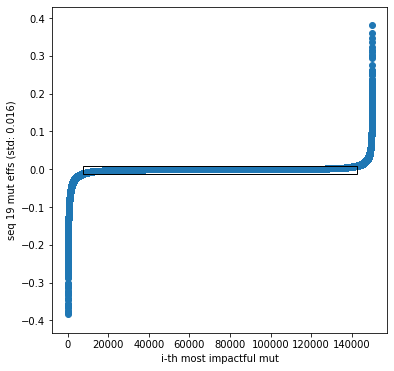

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# sample_seqs = np.random.random_integers(0, n_seqs, size=4)
y = np.sort(np_pred_mean_diffs[:, :, :, 1].reshape(-1))
x = np.arange(0, len(y))
xq1, xq2 = np.quantile(x, (.05, .95))
yq1, yq2 = np.quantile(y, (.05, .95))
rect = patches.Rectangle((xq1, yq1), xq2 - xq1, yq2 - yq1, fill=False, edgecolor='black')
rect = ax.add_patch(rect)
ax.scatter(x, y)
xlabel = "i-th most impactful mut"
ylabel = "seq {i} mut effs (std: {stddev:.3f})".format(i=i, stddev=np.std(y))
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel);

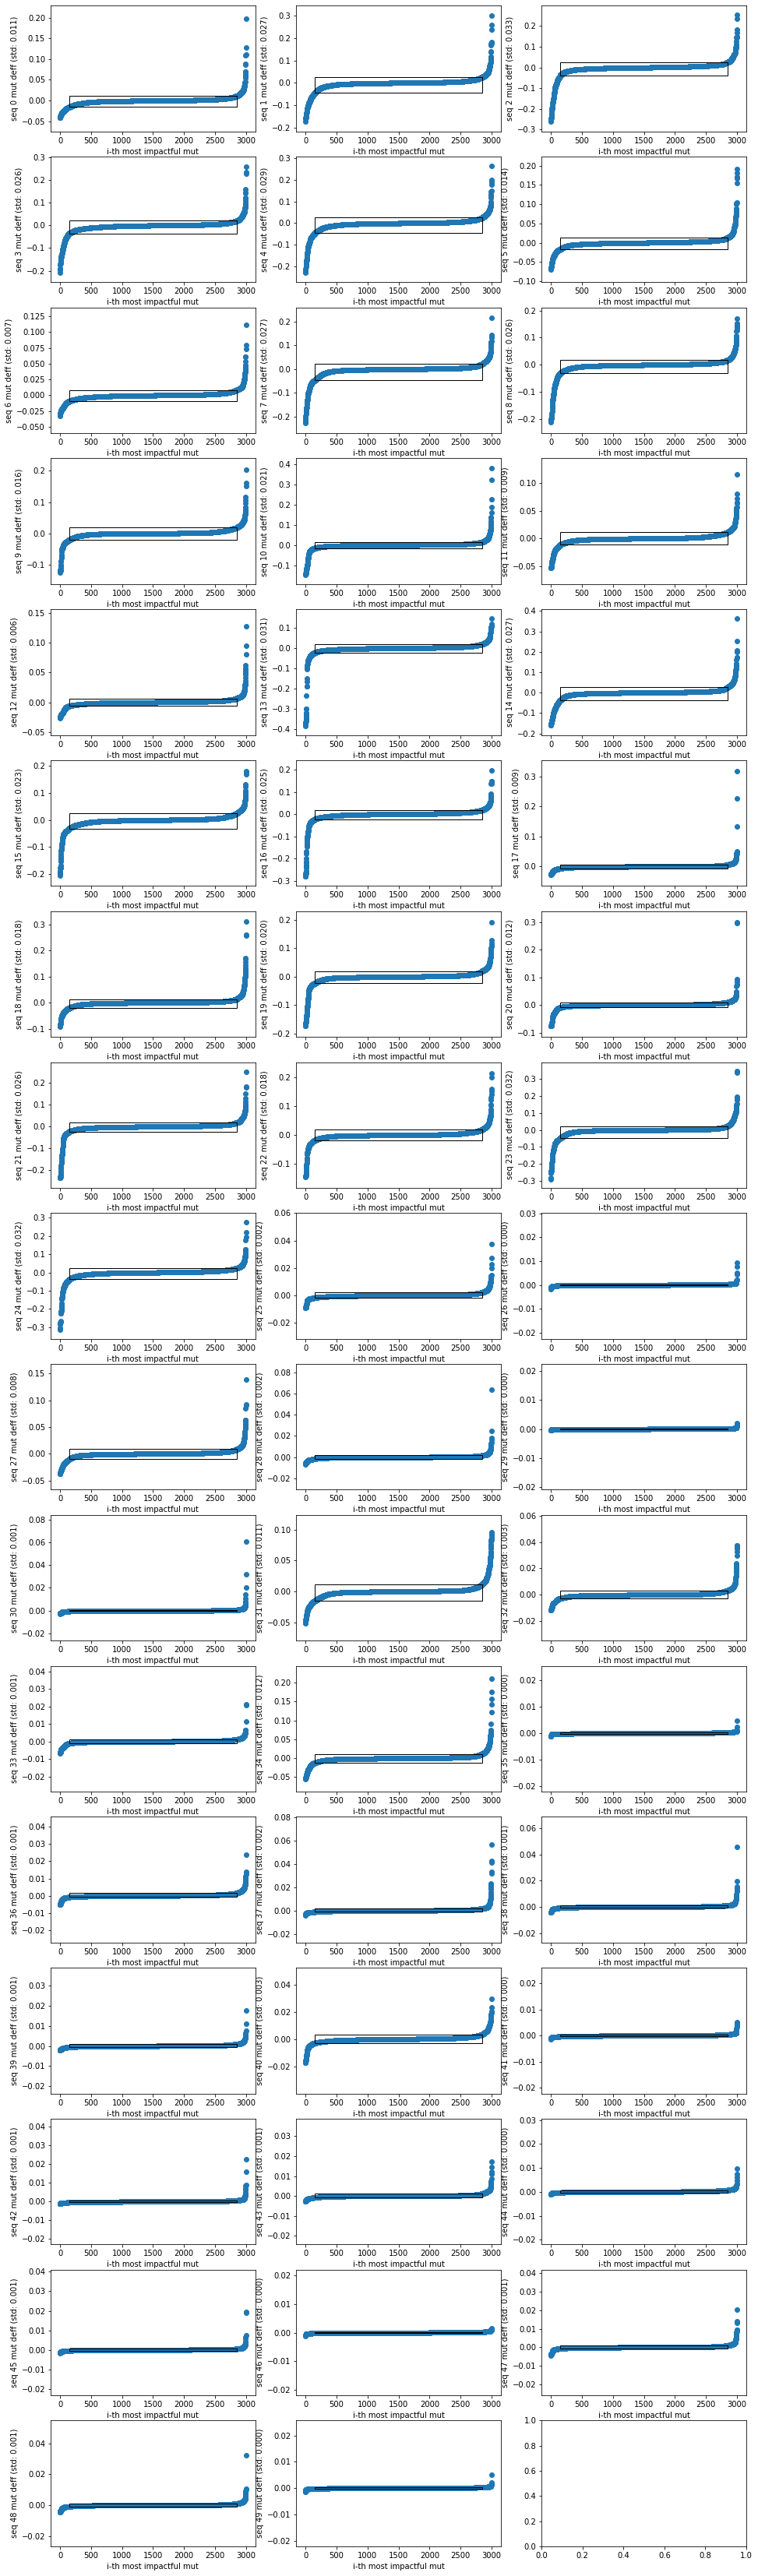

In [68]:
from matplotlib import patches
from matplotlib import cm

cols, margin = 3, 10 # margin determined empirically
fig, axs = plt.subplots(math.ceil(n_seqs / float(cols)), cols, figsize=(16, n_seqs + margin))
for i in range(n_seqs):
    ax = axs[i // cols, i % cols]

    y = np.sort(np_pred_mean_diffs[i, :, :, 1].reshape(-1))
    x = np.arange(0, len(y))
    xq1, xq2 = np.quantile(x, (.05, .95))
    yq1, yq2 = np.quantile(y, (.05, .95))
    rect = patches.Rectangle((xq1, yq1), xq2 - xq1, yq2 - yq1, fill=False, edgecolor='black')
    rect = ax.add_patch(rect)
    ax.scatter(x, y)
    xlabel = "i-th most impactful mut"
    ylabel = "seq {i} mut deff (std: {stddev:.3f})".format(i=i, stddev=np.std(y))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [117]:
neg_sig_muts, pos_sig_muts = [], []
for i in range(n_seqs // 2):
    
    seq = seqs[i, :, :]
    mut_effs = rank_mutations_by_impact(seq, np_pred_mean_diffs[i], batch_size)
    mut_eff_order_stats = np.sort(np_pred_mean_diffs[i, :, :, 1].reshape(-1))
    lq, uq = np.quantile(y, (.025, .975))
    qs = int(len(mut_eff_order_stats) * .05)
    lql, uql = mut_effs[:qs], mut_effs[-qs:]
    neg_sig_muts.append(lql)
    pos_sig_muts.append(uql)

In [135]:
print(len(neg_sig_muts[0]))

150


In [136]:
context_sizes = [7, 8, 15]
neg_eff_kmer_counts = {context_size: {} for context_size in context_sizes}

for i, effs in enumerate(neg_sig_muts):
    seq_one_hot = seqs[i, :, :]
    seq = one_hot_decode(seq_one_hot)
    for eff in effs:
        seq_pos, nt_idx = eff.seq_idx
        for context_size in context_sizes:
            neg_eff_count_for_size = neg_eff_kmer_counts[context_size]
            for shift_left in range(context_size):
                seq_context = seq[seq_pos - shift_left: seq_pos - shift_left + context_size]
                neg_eff_count_for_size[seq_context] = neg_eff_count_for_size.setdefault(seq_context, 0) + 1

In [139]:
ordered_neg_eff_kmer_counts = [(k, v) for k, v in sorted(neg_eff_kmer_counts[7].items(), key=lambda item: item[1], reverse=True)]

In [140]:
ordered_neg_eff_kmer_counts

[('AAAAAAA', 126),
 ('GTAAACA', 120),
 ('CAAACAT', 84),
 ('ACAAACA', 81),
 ('AGTAAAC', 80),
 ('AAACAAA', 63),
 ('TGTTTAC', 63),
 ('AAACATG', 61),
 ('GTCAACA', 60),
 ('TAAACAA', 60),
 ('AAGTAAA', 59),
 ('GTAAATA', 59),
 ('TACAAAC', 54),
 ('ATTTACA', 53),
 ('CAAAGTC', 53),
 ('TACTTTG', 52),
 ('CCAAAGT', 50),
 ('AAATATT', 49),
 ('TACAAAG', 48),
 ('GTACAAA', 47),
 ('ACATAGC', 46),
 ('AATATTT', 46),
 ('TTTACAT', 46),
 ('ACTTTGA', 45),
 ('CAAAGCT', 44),
 ('TTTGCAA', 43),
 ('ATCAAAG', 43),
 ('GCAAACA', 43),
 ('TTGCGCA', 41),
 ('TTATTTA', 40),
 ('TTACATA', 40),
 ('AAAGTAA', 40),
 ('TATTGAT', 40),
 ('TTGACCT', 40),
 ('ACATTTC', 40),
 ('TTTACAA', 40),
 ('TTTGCTT', 39),
 ('TAAACAT', 39),
 ('AACATGT', 39),
 ('ATTGCGC', 39),
 ('AGTAAAT', 39),
 ('TATTTAC', 39),
 ('GAGTAAA', 39),
 ('GGTAAAC', 38),
 ('CAAATAT', 38),
 ('TGTCAAC', 38),
 ('AAGTCCA', 38),
 ('TCAACAA', 38),
 ('AGGTAAA', 38),
 ('GATCAAA', 38),
 ('AGATCAA', 38),
 ('TGTACTT', 37),
 ('AACAAAC', 37),
 ('TCAAAGG', 37),
 ('AAAGTCC', 37),
 ('GTGTC

In [141]:
ordered_neg_eff_kmer_counts = [(k, v) for k, v in sorted(neg_eff_kmer_counts[8].items(), key=lambda item: item[1], reverse=True)]

In [142]:
ordered_neg_eff_kmer_counts

[('AAAAAAAA', 128),
 ('AGTAAACA', 92),
 ('GTAAACAA', 69),
 ('ACAAACAT', 65),
 ('CAAACATG', 64),
 ('CCAAAGTC', 55),
 ('AAGTAAAC', 45),
 ('AAAGTAAA', 45),
 ('ATTGCGCA', 45),
 ('AGTAAATA', 45),
 ('TGTCAACA', 44),
 ('GTCAACAA', 44),
 ('GATCAAAG', 44),
 ('AGATCAAA', 44),
 ('TTTACATA', 43),
 ('TAAACAAA', 43),
 ('TACAAACA', 42),
 ('CAAAGTCC', 42),
 ('GTGTCAAC', 42),
 ('ATGTTTAC', 42),
 ('AGAGTAAA', 42),
 ('CAAATATT', 41),
 ('TATTTACA', 41),
 ('TGCAAACA', 41),
 ('AAGGTAAA', 41),
 ('AAAAGTAA', 40),
 ('TTACATAG', 40),
 ('AAACATGT', 40),
 ('TTTTTTTT', 40),
 ('GAGATCAA', 40),
 ('CAAGGTCA', 39),
 ('TTATTTAC', 39),
 ('TGTACTTT', 38),
 ('ACAAATAT', 38),
 ('TACATAGC', 38),
 ('AAGTCCAA', 38),
 ('AGGTCACA', 38),
 ('GGTAAACA', 37),
 ('TTTGCAAA', 37),
 ('TCCAAAGT', 37),
 ('CAAGGTAA', 37),
 ('GGTCACAC', 36),
 ('CCAAGGTA', 36),
 ('GTACAAAC', 35),
 ('ATTTACAA', 35),
 ('TTGCAAAC', 35),
 ('AGTACAAA', 35),
 ('AATAAACA', 33),
 ('ATCCAAAG', 33),
 ('ATTATTTA', 33),
 ('CAAAGCTC', 33),
 ('AAATATTT', 32),
 ('GGACTCTG

In [143]:
ordered_neg_eff_kmer_counts = [(k, v) for k, v in sorted(neg_eff_kmer_counts[15].items(), key=lambda item: item[1], reverse=True)]

In [144]:
ordered_neg_eff_kmer_counts

[('AAAAAAAAAAAAAAA', 135),
 ('TTTTTTTTTTTTTTT', 44),
 ('ACAAACATGACCTTG', 43),
 ('GACAAACATGACCTT', 42),
 ('AACATGACCTTGCCC', 41),
 ('AAACATGACCTTGCC', 41),
 ('CAAACATGACCTTGC', 41),
 ('AGACAAACATGACCT', 41),
 ('ACATGACCTTGCCCT', 40),
 ('AAGACAAACATGACC', 39),
 ('CATGACCTTGCCCTC', 39),
 ('TAAGTAAACAAAGAG', 38),
 ('AGAGTAAACAAGAGC', 38),
 ('CAAGACAAACATGAC', 37),
 ('AGAGTAAATAATGAC', 37),
 ('AAGAGTAAACAAGAG', 37),
 ('ATGACCTTGCCCTCA', 36),
 ('AAGTAAACAAAGAGG', 36),
 ('ATAAGTAAACAAAGA', 36),
 ('GCTCCAAGGTAAACA', 36),
 ('GAGTAAATAATGACA', 36),
 ('CAGAGTAAATAATGA', 36),
 ('GAGTAAACAAGAGCA', 36),
 ('GTCTACTTTGAACCT', 35),
 ('AGTAAACAAAGAGGC', 35),
 ('AGTAAACAAGAGCAG', 35),
 ('CAAAGTCTTTCACAA', 35),
 ('AAAAAAAAGTAAACA', 34),
 ('AACAAATATTGATTG', 34),
 ('CAACAAATATTGATT', 34),
 ('ACAACAAATATTGAT', 34),
 ('GCAAGACAAACATGA', 34),
 ('AAAGTAAATAGAGTG', 34),
 ('GAAAAGTAAATAGAG', 34),
 ('AATAAGTAAACAAAG', 34),
 ('AGCTCCAAGGTAAAC', 34),
 ('TGTTTACATAGCCTC', 34),
 ('ATGTTTACATAGCCT', 34),
 ('AGTAAATA

In [ ]:
known_foxa1_motifs = []